In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), 'resnet'))
sys.path.append(parent_dir)

import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from resnet_18 import *

from scipy.integrate import simpson

In [2]:
print(torch.cuda.is_available())

True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
%run utils.ipynb

In [5]:
batch_size = 8
train_path = '../datasets/imagenette2/train'
val_path = '../datasets/imagenette2/val'

In [6]:
train_dataloader = DataLoader(datasets.ImageFolder(train_path, transform = transforms.Compose([
                                                                    transforms.RandomResizedCrop(224),
                                                                    transforms.RandomHorizontalFlip(),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std=[0.229, 0.224, 0.225])
                                                            ])), batch_size = batch_size, shuffle=True, num_workers=4, pin_memory=True)

test_dataloader = DataLoader(datasets.ImageFolder(val_path,
                                                               transform=transforms.Compose([
                                                                   transforms.ToTensor(),
                                                                   transforms.Resize([224, 224]),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std=[0.229, 0.224, 0.225])
                                                               ])),batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)


In [7]:
classes = ['tench', 'springer', 'casette_player', 'chain_saw','church', 'French_horn', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute']


In [8]:
criterion = nn.CrossEntropyLoss(reduction="mean").cuda()

## Normal Model

In [9]:
MODEL_PATH = "models/0_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

In [24]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

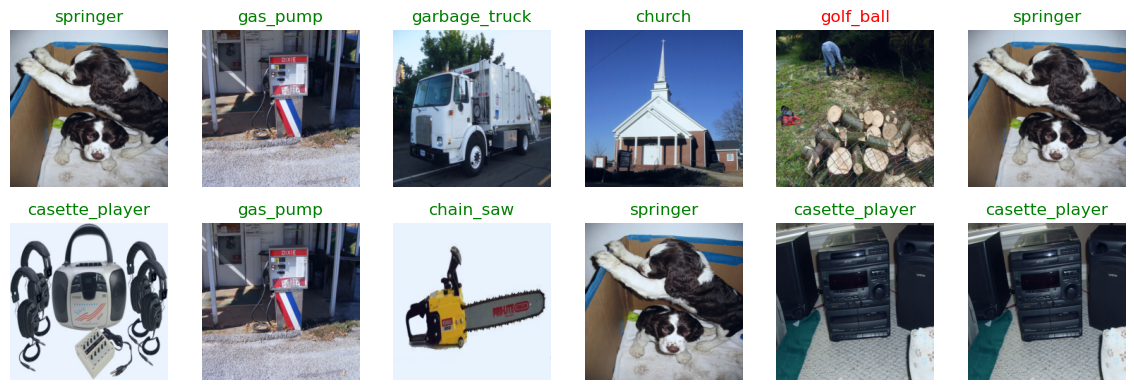

In [25]:
fig = plt.figure(figsize=(12, 4))
indexes=[]
rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model(img_temp))
    fig.add_subplot(rows, cols, i)
    # img = img.permute(1, 2, 0)    # CWH --> WHC
    img = img.squeeze().permute(0, 1) if img.dim() == 3 and img.shape[0] == 1 else img.permute(1, 2, 0)

    img_display = img.cpu().numpy()
    # This formula scales the data to the [0, 1] range
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    plt.imshow(img_display, cmap='gray')
    # plt.imshow(img.cpu().numpy(), cmap='gray')
    if label_pred == label_gt:
        plt.title(classes[label_pred], color='g') # for correct prediction
    else:
        plt.title(classes[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();
plt.show()

In [26]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [27]:
gc.collect()
torch.cuda.empty_cache()
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

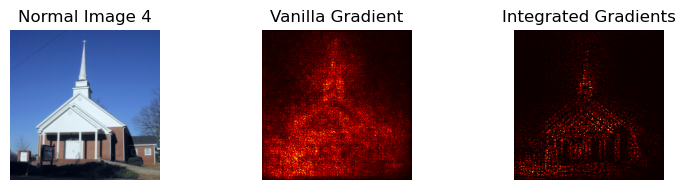

In [28]:
index = indexes[3]
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, 'resnet_normal')

## Prune 10%

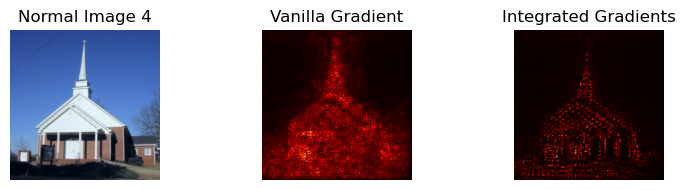

In [29]:
MODEL_PATH = "models/1_10_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, 'resnet_10')

## Prune 20%

In [30]:
MODEL_PATH = "models/1_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

In [31]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [32]:
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

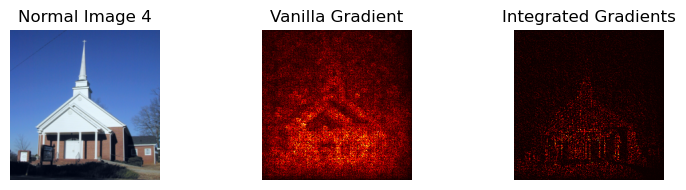

In [33]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, 'resnet_20')

## Prune 30%

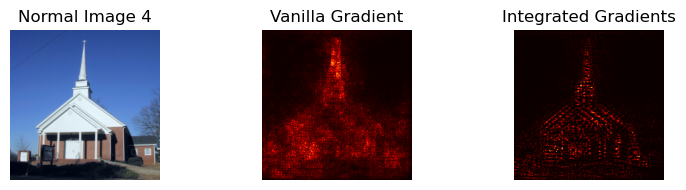

In [34]:
MODEL_PATH = "models/2_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, 'resnet_30')

## Prune 50%

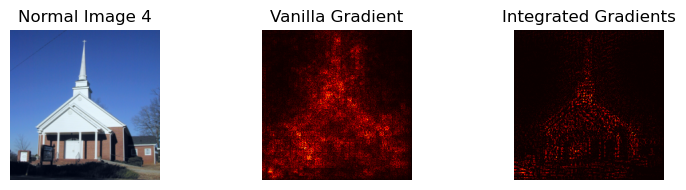

In [35]:
MODEL_PATH = "models/12_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, 'resnet_50')

## Prune 70%

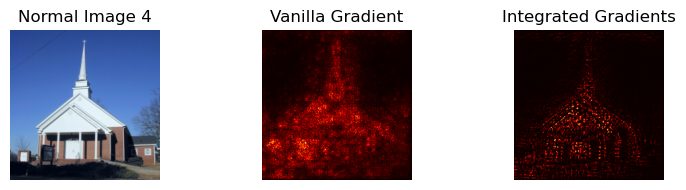

In [36]:
MODEL_PATH = "models/29_model_lt.pth.tar"
model = torch.load(MODEL_PATH, map_location=device, weights_only=False)

gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, 'resnet_70')